# In depth analysis of the BDD100K dataset 

## Overview

This notebook is used to analyze the BDD100K dataset in detail.
The analysis is given after each section and also copy pasted in the `docs/data_analysis.md` file.


In [24]:
import json
from collections import Counter
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List, Set
from collections import Counter, defaultdict


From the 01_EDA_RawData.ipynb we know the detection classes. So make a list of it:

In [3]:
detection_classes = [
    "person",
    "rider",
    "car",
    "bus",
    "truck",
    "bike",
    "motor",
    "traffic light",
    "traffic sign",
    "train",
]

Since, the BDD100K dataset is a large dataset involving segmentation masks, it is important to parse that data and extract whats needed for the object detection task.
The parquet files are created which are easy to load. 

In [11]:
train_parquet = Path("../../data/parsed_data/train_data.parquet")
val_parquet = Path("../../data/parsed_data/val_data.parquet")

train_df = pd.read_parquet(train_parquet)
val_df = pd.read_parquet(val_parquet)

Lets visualize the class distribution in log scale. (As we can see that the dataset is very imbalanced from 01_EDA_RawData.ipynb)

Train: category
bike               7210
bus               11672
car              713211
motor              3002
person            91349
rider              4517
traffic light    186117
traffic sign     239686
train               136
truck             29971
Name: count, dtype: int64
Val: category
bike               1007
bus                1597
car              102506
motor               452
person            13262
rider               649
traffic light     26885
traffic sign      34908
train                15
truck              4245
Name: count, dtype: int64


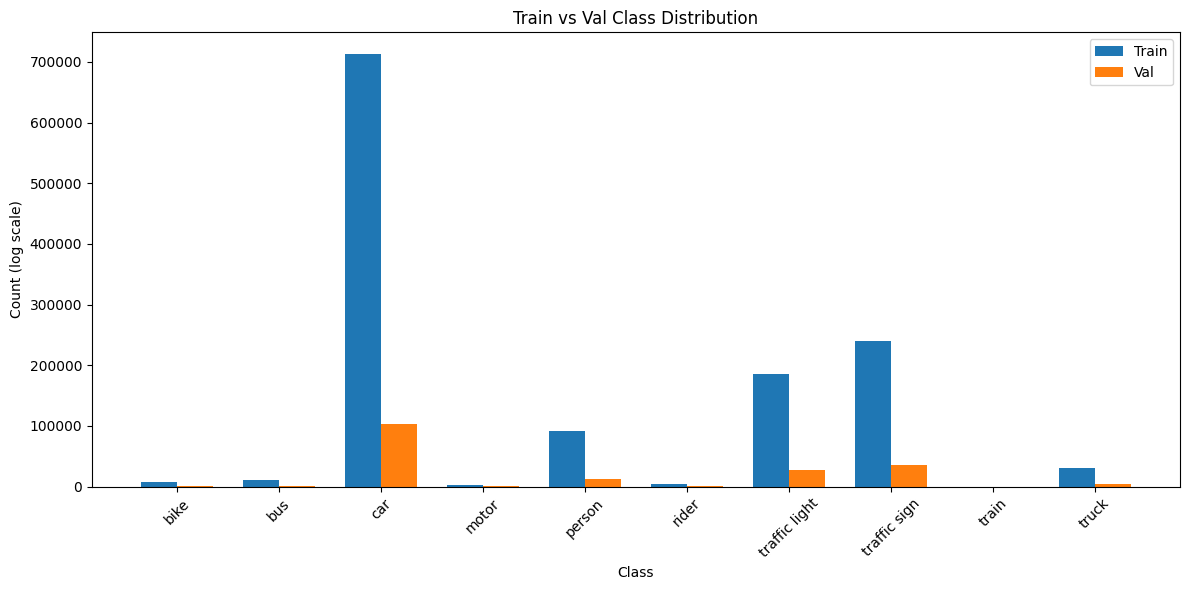

In [13]:

def class_distribution(
    train_parquet: Path,
    val_parquet: Path
) -> Tuple[pd.Series, pd.Series]:
    """
    Compute per-class distribution in train and val sets.

    Args:
        train_parquet (Path): Path to train_data.parquet
        val_parquet (Path): Path to val_data.parquet

    Returns:
        Tuple[pd.Series, pd.Series]: (train_counts, val_counts)
    """
    train_counts = train_parquet["category"].value_counts().sort_index()
    val_counts = val_parquet["category"].value_counts().sort_index()

    return train_counts, val_counts



train_counts, val_counts = class_distribution(
    train_df, val_df
)

print("Train:", train_counts)
print("Val:", val_counts)

classes = train_counts.index
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_counts.values, 
        width, label='Train')
plt.bar(x + width/2, val_counts.values, 
        width, label='Val')

plt.xlabel("Class")
plt.ylabel("Count (log scale)")
plt.title("Train vs Val Class Distribution")
#plt.yscale('log')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The dataset is highly imbalanced, with cars dominating (>55% of labels) and some classes like train almost 0.
This will cause the model to perform very well on frequent classes but poorly on rare ones, leading to low recall and AP for underrepresented categories.

Train avg objects/image: 18.4199218470435
Val avg objects/image: 18.5526


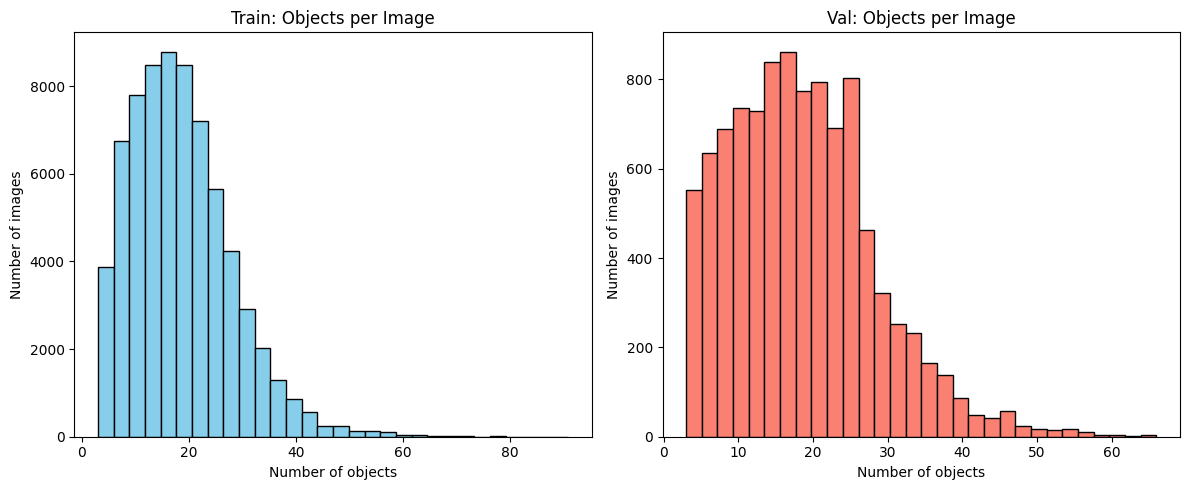

In [ ]:
def objects_per_image(
    df: pd.DataFrame,
    detection_classes: List[str]
) -> Tuple[List[int], float]:
    """
    Count number of detection objects per image.

    Args:
        df (pd.DataFrame): Input parquet as DataFrame.
        detection_classes (List[str]): Detection class names.

    Returns:
        List[int]: Number of objects per image 
    """
    df = df[df["category"].isin(detection_classes)]
    obj_counts = df.groupby("image_name").size().tolist()

    total_objs = sum(obj_counts)
    num_images = len(obj_counts)
    avg = total_objs / num_images if num_images > 0 else 0.0
    return obj_counts, avg

train_obj_counts, train_avg = objects_per_image(train_df, detection_classes)
val_obj_counts, val_avg = objects_per_image(val_df, detection_classes)

print("Train avg objects/image:", train_avg)
print("Val avg objects/image:", val_avg)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_obj_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Train: Objects per Image")
plt.xlabel("Number of objects")
plt.ylabel("Number of images")

plt.subplot(1, 2, 2)
plt.hist(val_obj_counts, bins=30, color='salmon', edgecolor='black')
plt.title("Val: Objects per Image")
plt.xlabel("Number of objects")
plt.ylabel("Number of images")

plt.tight_layout()
plt.show()

So distribution of objects per image in both trian and val follow similar structure. So, the split is good and balanced in terms of objects per image.
Most images contain about 18 objects/image with a few crowded scenes even having 50+ objects. This also tells that, there are more occluded objects in the scene. So, the model must handle overlapping boxes, increasing the risk of missed detections

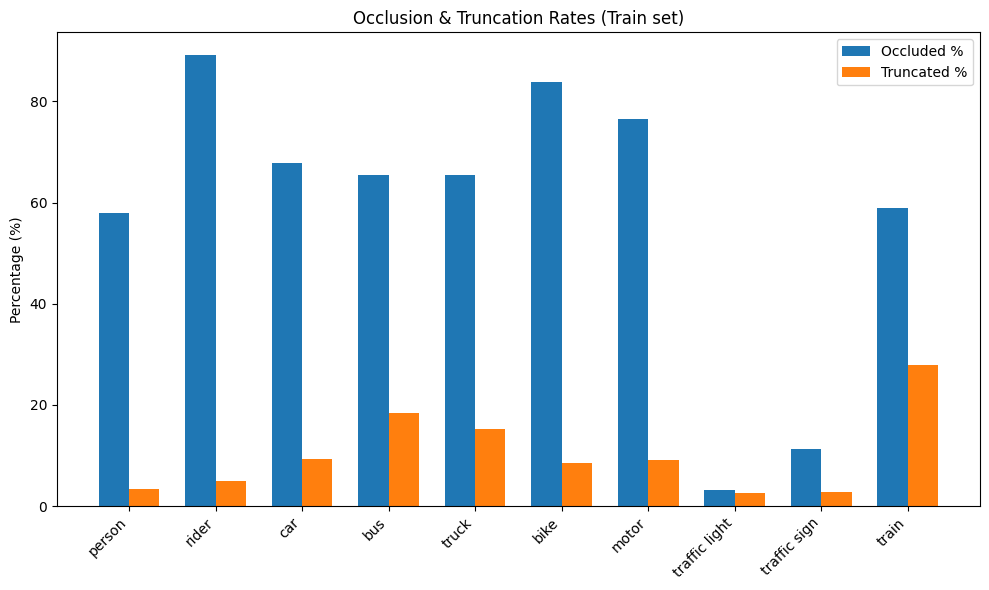

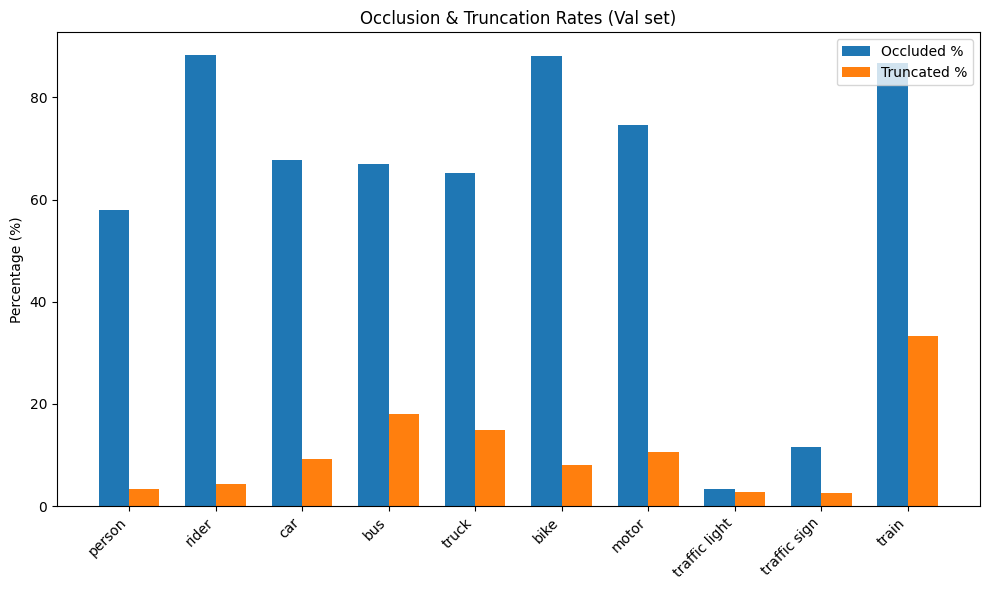

In [ ]:
def attribute_rate_per_class_df(df, attr_name, detection_classes):
    """
    Compute the percentage of objects with a given attribute  per class.

    Args:
        df : Loaded annotations DataFrame (train or val).
        attr_name : Attribute column name .
        detection_classes (List[str]): List of class names to compute rates for.

    Returns:
        Dict[str, float]: Class name → percentage of attribute=True
    """
    rates = {}
    for cat in detection_classes:
        class_df = df[df["category"] == cat]
        if not class_df.empty:
            attr_true = class_df[attr_name].sum()  # because it's boolean
            rates[cat] = attr_true / len(class_df)
        else:
            rates[cat] = 0.0
    return rates


train_occ_rates = attribute_rate_per_class_df(train_df, "occluded", detection_classes)
train_trunc_rates = attribute_rate_per_class_df(train_df, "truncated", detection_classes)

val_occ_rates = attribute_rate_per_class_df(val_df, "occluded", detection_classes)
val_trunc_rates = attribute_rate_per_class_df(val_df, "truncated", detection_classes)

x = np.arange(len(detection_classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, [train_occ_rates[c] * 100 for c in detection_classes], width, label='Occluded %')
ax.bar(x + width/2, [train_trunc_rates[c] * 100 for c in detection_classes], width, label='Truncated %')

ax.set_ylabel('Percentage (%)')
ax.set_title('Occlusion & Truncation Rates (Train set)')
ax.set_xticks(x)
ax.set_xticklabels(detection_classes, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, [val_occ_rates[c] * 100 for c in detection_classes], width, label='Occluded %')
ax.bar(x + width/2, [val_trunc_rates[c] * 100 for c in detection_classes], width, label='Truncated %')

ax.set_ylabel('Percentage (%)')
ax.set_title('Occlusion & Truncation Rates (Val set)')
ax.set_xticks(x)
ax.set_xticklabels(detection_classes, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()


Both train and val sets have similar occlusion/truncation patterns, so no data split bias. As discussed earlier, due to high oclusion, model might face partial visibility and this might increase False Negative. eg. a car might be occluded by another car, so the model might miss it. Moderate truncation especially for train, bus, truck is expected as they are longer objects and cannot be completely captured in the image.

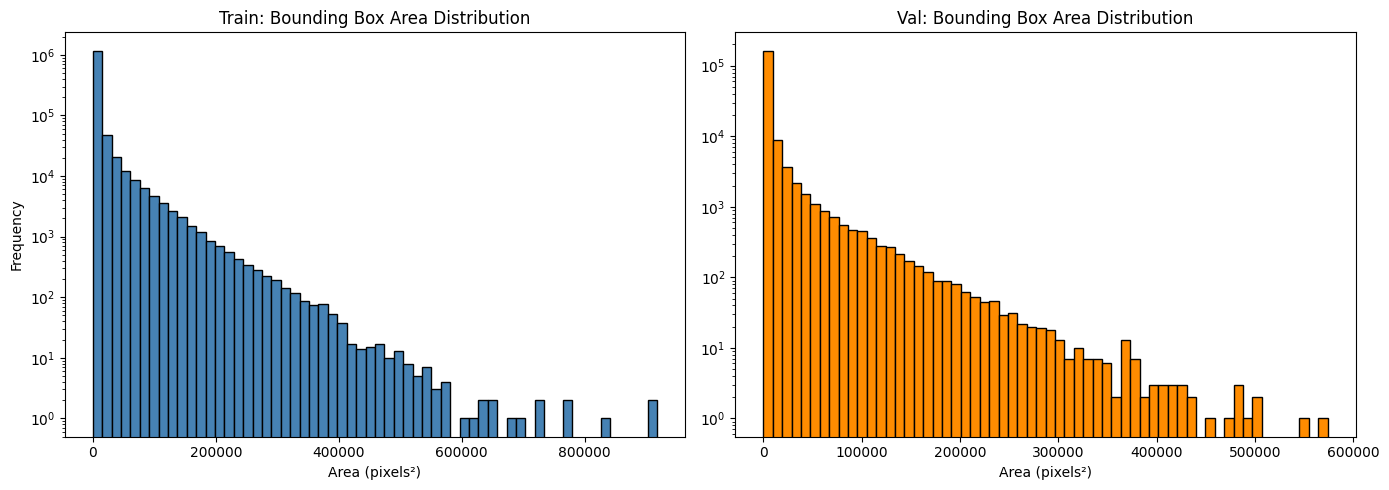

Train: 200 tiny boxes (area < 16 pixels²)
Val:   33 tiny boxes (area < 16 pixels²)


In [ ]:
def object_area_distribution_df(df, min_area=16):
    """
    Compute bounding box area distribution and detect tiny boxes.

    Args:
        df: Object-level annotations DataFrame.
        min_area (int): Area threshold to flag tiny boxes.

    Returns:
        Tuple[List[float], List[float]]: (areas, tiny_boxes)
    """
    widths = (df["x2"] - df["x1"]).clip(lower=0)
    heights = (df["y2"] - df["y1"]).clip(lower=0)
    areas = (widths * heights).tolist()
    tiny_boxes = [a for a in areas if a < min_area]
    return areas, tiny_boxes

# Compute areas
train_areas, train_tiny = object_area_distribution_df(train_df)
val_areas, val_tiny = object_area_distribution_df(val_df)

# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].hist(train_areas, bins=60, color="steelblue", edgecolor="black")
ax[0].set_title("Train: Bounding Box Area Distribution")
ax[0].set_xlabel("Area (pixels²)")
ax[0].set_ylabel("Frequency")
ax[0].set_yscale("log")

ax[1].hist(val_areas, bins=60, color="darkorange", edgecolor="black")
ax[1].set_title("Val: Bounding Box Area Distribution")
ax[1].set_xlabel("Area (pixels²)")
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

# Tiny box report
print(f"Train: {len(train_tiny)} tiny boxes (area < 16 pixels²)")
print(f"Val:   {len(val_tiny)} tiny boxes (area < 16 pixels²)")

Good balance between train and val sets. This aligns with earlier findings like high object density (18 objects/image) and frequent occlusion mean many objects are either far from the camera or partially visible, resulting in small bounding boxes. 

For the model, this suggests precision for small objects will be challenging - for classes like traffic lights/signs, bikes, and persons. Larger objects (buses, trucks, close-up cars) will be easier to detect.

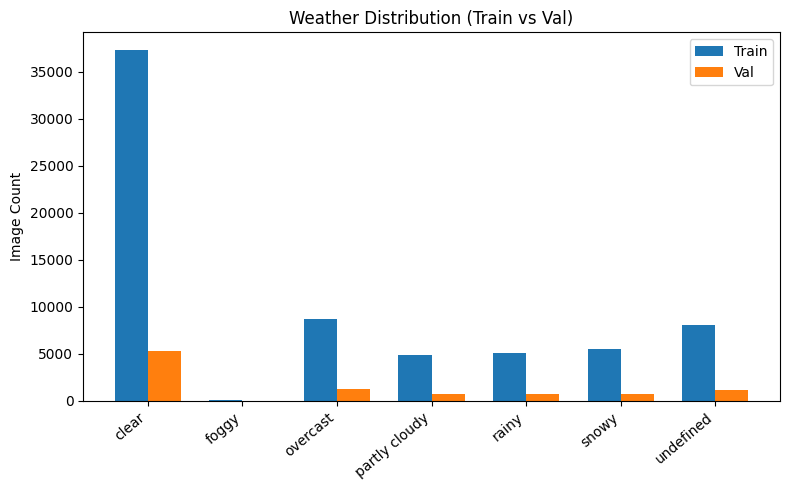

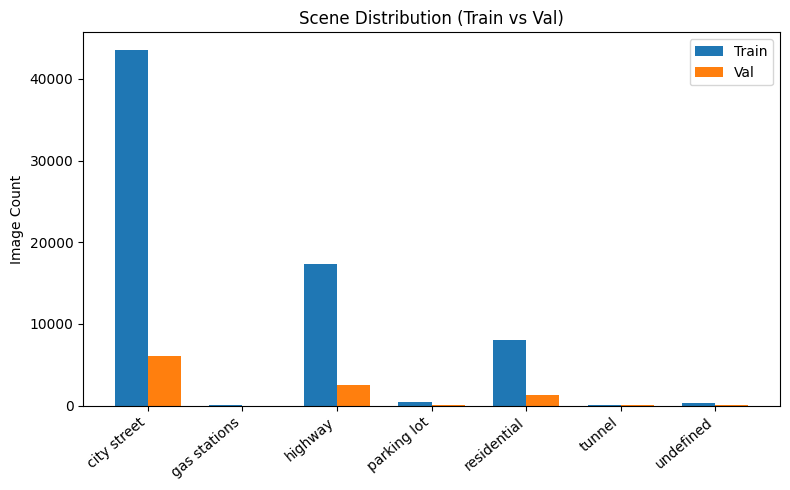

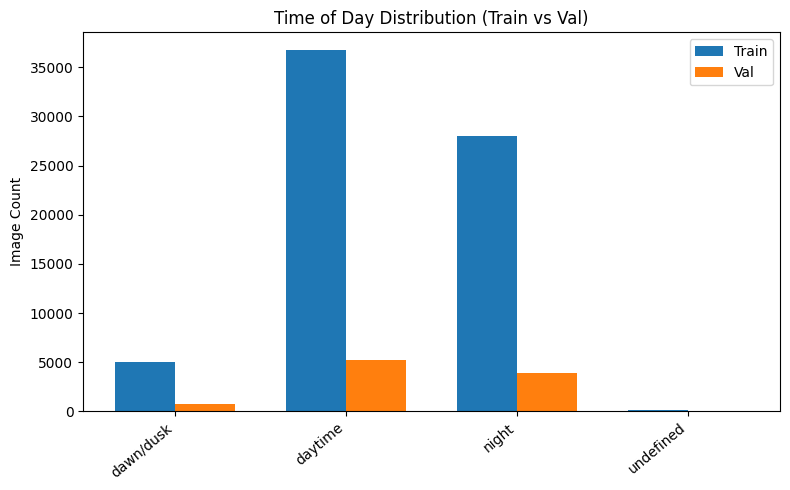

In [ ]:

def plot_image_attribute_distribution(df_train, df_val, attr_key, title):
    """
    Plot distribution of image-level attribute (scene, weather, timeofday) from train and val DataFrames.
    """
    def extract_attr_counts(df, attr_key):
        df_unique = df[["image_name", attr_key]].drop_duplicates()
        return df_unique[attr_key].value_counts()

    train_counts = extract_attr_counts(df_train, attr_key)
    val_counts = extract_attr_counts(df_val, attr_key)

    all_values = sorted(set(train_counts.index).union(val_counts.index))
    train_vals = [train_counts.get(v, 0) for v in all_values]
    val_vals = [val_counts.get(v, 0) for v in all_values]

    x = range(len(all_values))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar([i - width/2 for i in x], train_vals, width, label="Train")
    plt.bar([i + width/2 for i in x], val_vals, width, label="Val")
    plt.xticks(ticks=x, labels=all_values, rotation=40, ha="right")
    plt.ylabel("Image Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_image_attribute_distribution(train_df, val_df, "weather", "Weather Distribution (Train vs Val)")
plot_image_attribute_distribution(train_df, val_df, "scene", "Scene Distribution (Train vs Val)")
plot_image_attribute_distribution(train_df, val_df, "timeofday", "Time of Day Distribution (Train vs Val)")


Weather distribution - Both train and val sets are dominated by clear-weather images which indicates that, cars are driven mostly in clear conditions. Foggy weather is extremely rare. 

Scene distribution - The dataset is heavily biased toward city street scenes, followed by highways. This reflects typical urban driving environments where the data was collected, with higher object density and more diverse traffic elements likely in city streets compared to other scenes like parking lots or tunnels.

Time of day - Daytime images dominate, and then night scenes. This reflects real-world driving habits, where most trips happen during the day and fewer during dawn or dusk because of the time duration. 

This domain imbalance could lead to reduced recall and higher misclassification rates in environments where there is less data points.

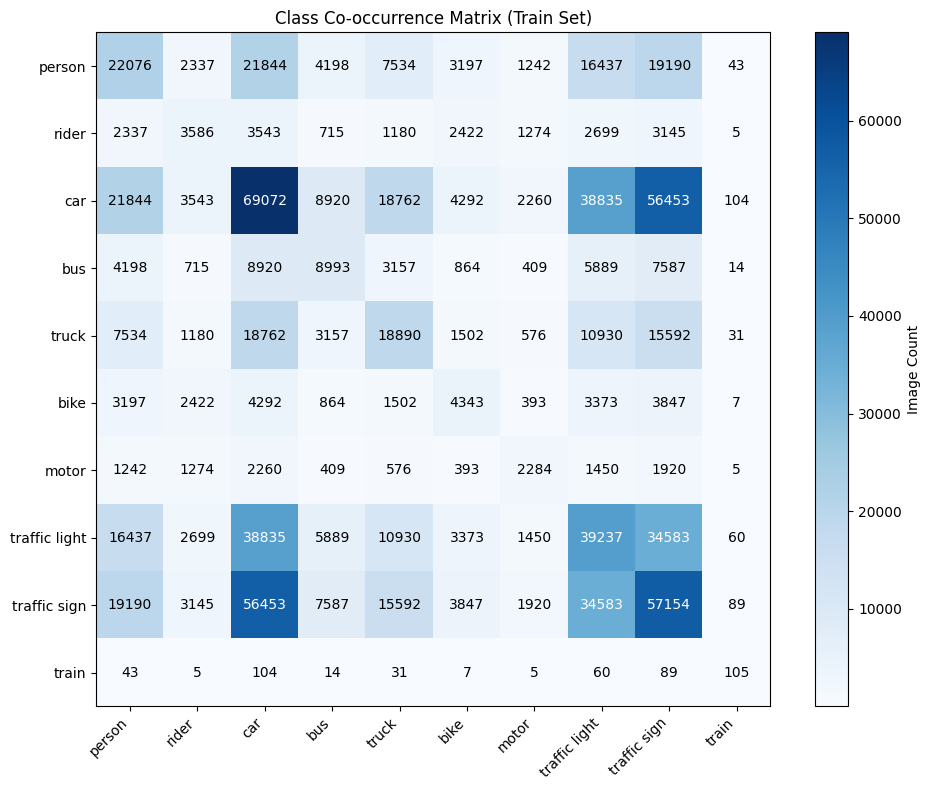

In [ ]:
def build_cooccurrence_matrix_df(df, detection_classes):
    """
    Build co-occurrence matrix from DataFrame.
    Rows/cols = classes, values = number of images where both appear.
    """
    cooc = pd.DataFrame(0, index=detection_classes, columns=detection_classes)

    grouped = df[df["category"].isin(detection_classes)].groupby("image_name")

    for _, group in grouped:
        classes_in_img = set(group["category"])
        for c1 in classes_in_img:
            for c2 in classes_in_img:
                cooc.loc[c1, c2] += 1

    return cooc

cooc_train = build_cooccurrence_matrix_df(train_df, detection_classes)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cooc_train.values, cmap="Blues")

ax.set_xticks(np.arange(len(detection_classes)))
ax.set_yticks(np.arange(len(detection_classes)))
ax.set_xticklabels(detection_classes, rotation=45, ha="right")
ax.set_yticklabels(detection_classes)

for i in range(len(detection_classes)):
    for j in range(len(detection_classes)):
        count = cooc_train.values[i, j]
        ax.text(j, i, str(count), ha="center", va="center", color="black" if count < cooc_train.values.max()/2 else "white")

ax.set_title("Class Co-occurrence Matrix (Train Set)")
plt.colorbar(im, ax=ax, label="Image Count")
plt.tight_layout()
plt.show()

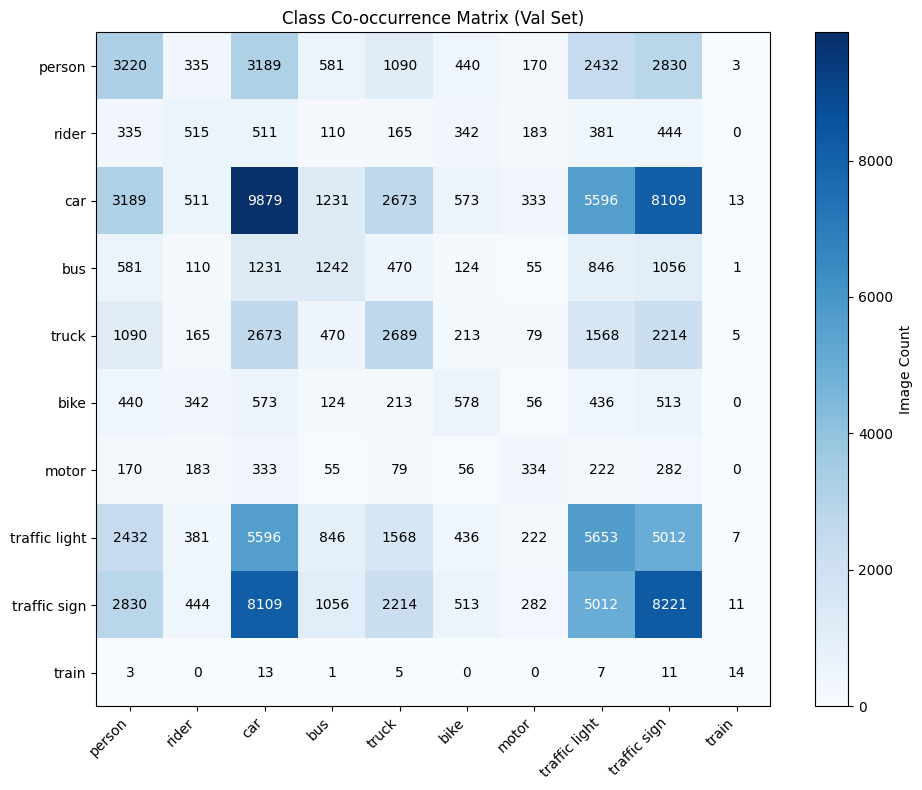

In [ ]:
cooc_val = build_cooccurrence_matrix_df(val_df, detection_classes)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cooc_val.values, cmap="Blues")

ax.set_xticks(np.arange(len(detection_classes)))
ax.set_yticks(np.arange(len(detection_classes)))
ax.set_xticklabels(detection_classes, rotation=45, ha="right")
ax.set_yticklabels(detection_classes)

for i in range(len(detection_classes)):
    for j in range(len(detection_classes)):
        count = cooc_val.values[i, j]
        ax.text(j, i, str(count), ha="center", va="center", color="black" if count < cooc_val.values.max()/2 else "white")

ax.set_title("Class Co-occurrence Matrix (Val Set)")
plt.colorbar(im, ax=ax, label="Image Count")
plt.tight_layout()
plt.show()



Car has the highest co-occurrence with almost every other class, which makes sense in road scenes where cars are the dominant object type. As stater earlier that, most of the images are from city streets, hence we see that car frequently appears with traffic lights and traffic signs also. Person also often co-occurs with cars, trucks, and traffic control objects, indicating pedestrian presence near roads. Truck–car and bus–car combinations are common in road scenes. Train has very low co-occurrence with all classes, which is expected as it is less rare to see trains in the city streets.

For model, car–traffic sign, car–traffic light will be easier to detect together because the model will repeatedly see them together. Rare combinations like train–X will be harder for the model to learn

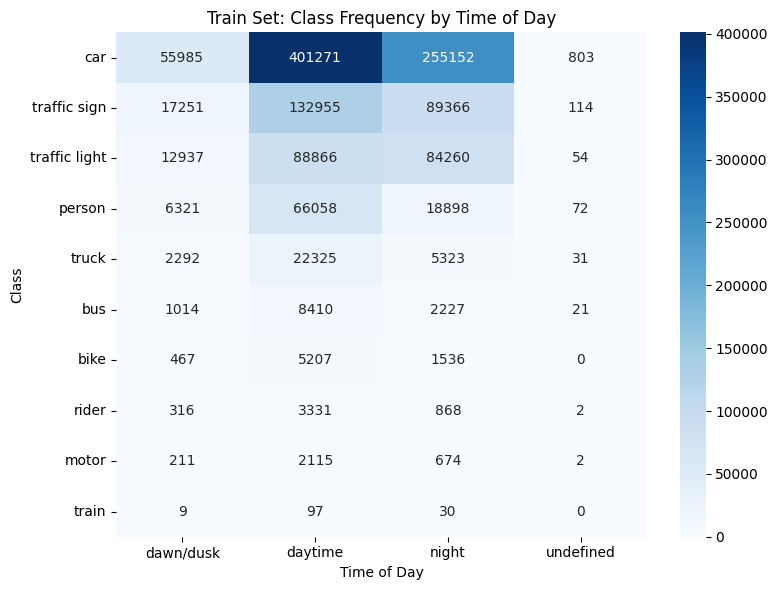

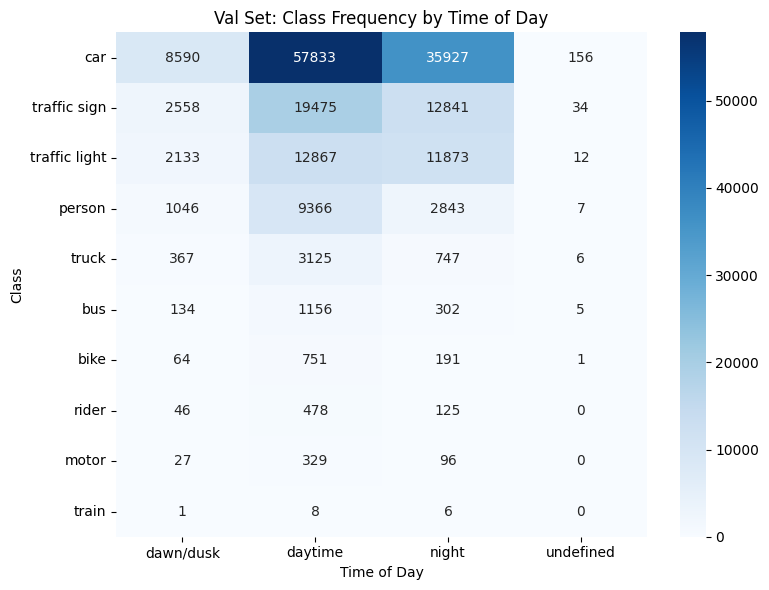

In [ ]:
def class_vs_timeofday_heatmap(df, split_name="Train"):
    """
    Plot heatmap of object count per (class, timeofday) for a given split.
    """

    df_filtered = df[df["category"].isin(detection_classes)]

    count_df = (
        df_filtered
        .groupby(["category", "timeofday"])
        .size()
        .reset_index(name="count")
        .pivot(index="category", columns="timeofday", values="count")
        .fillna(0)
        .astype(int)
    )

    count_df["Total"] = count_df.sum(axis=1)
    count_df = count_df.sort_values("Total", ascending=False).drop(columns="Total")

    plt.figure(figsize=(8, 6))
    sns.heatmap(count_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Set: Class Frequency by Time of Day")
    plt.ylabel("Class")
    plt.xlabel("Time of Day")
    plt.tight_layout()
    plt.show()

class_vs_timeofday_heatmap(train_df, "Train")
class_vs_timeofday_heatmap(val_df, "Val")

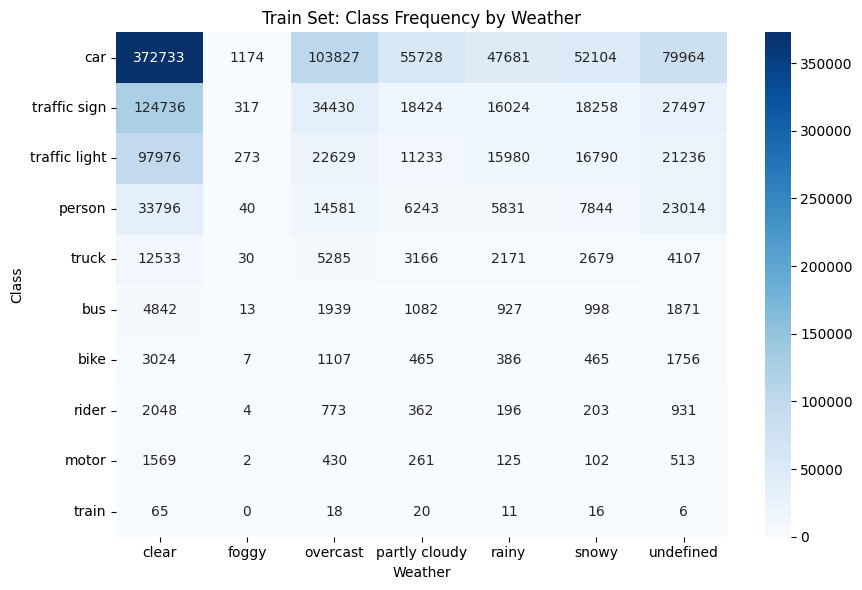

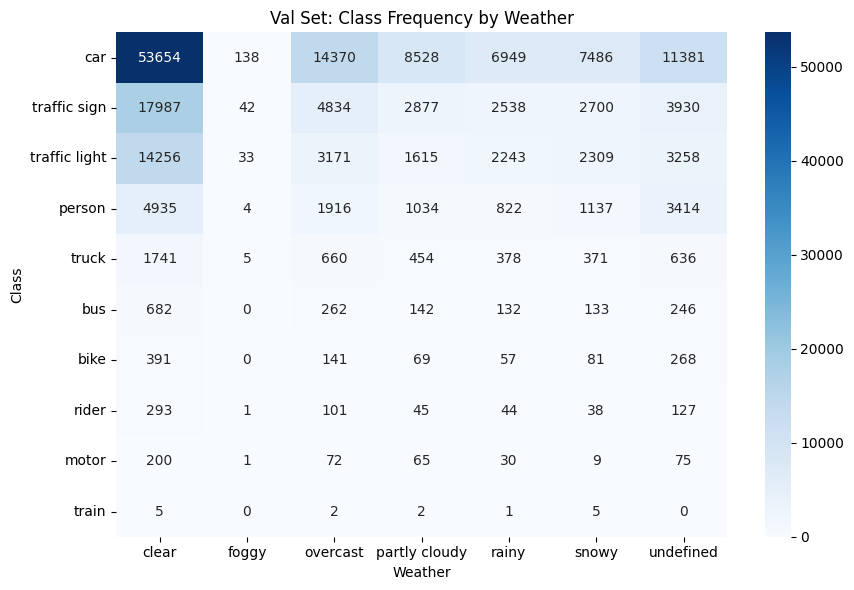

In [ ]:
def class_vs_weather_heatmap(df, split_name="Train"):
    """
    Plot heatmap of object count per (class, weather) for a given split.
    """
    df_filtered = df[df["category"].isin(detection_classes)]

    count_df = (
        df_filtered
        .groupby(["category", "weather"])
        .size()
        .reset_index(name="count")
        .pivot(index="category", columns="weather", values="count")
        .fillna(0)
        .astype(int)
    )

    count_df["Total"] = count_df.sum(axis=1)
    count_df = count_df.sort_values("Total", ascending=False).drop(columns="Total")

    plt.figure(figsize=(9, 6))
    sns.heatmap(count_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Set: Class Frequency by Weather")
    plt.ylabel("Class")
    plt.xlabel("Weather")
    plt.tight_layout()
    plt.show()

class_vs_weather_heatmap(train_df, "Train")
class_vs_weather_heatmap(val_df, "Val")

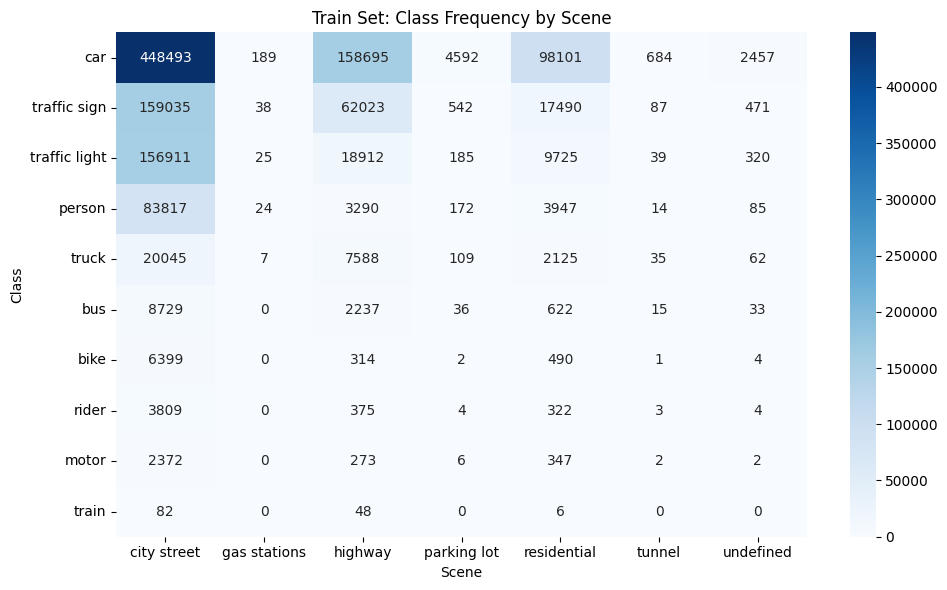

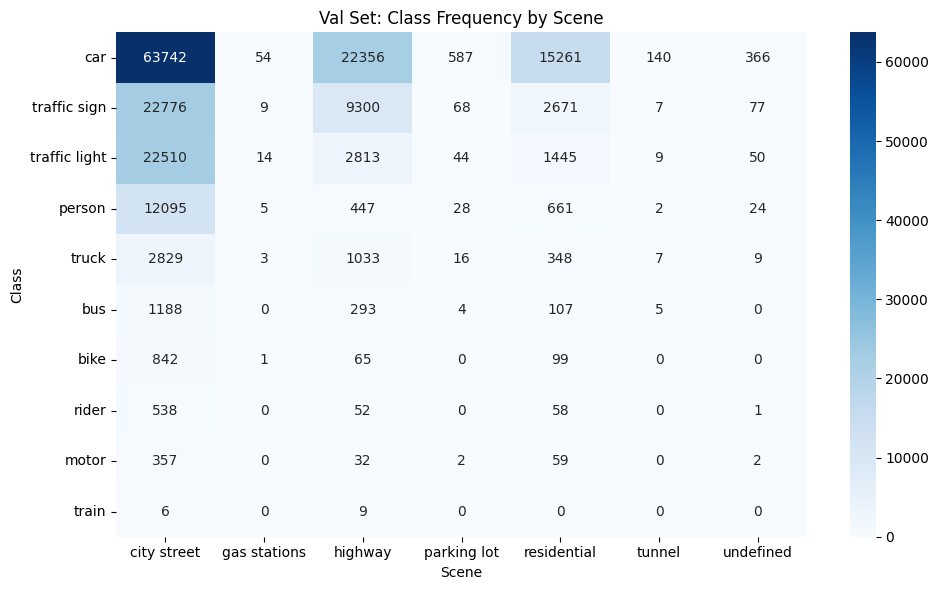

In [ ]:
def class_vs_scene_heatmap(df, split_name):
    """
    Plot heatmap of object count per (class, scene) for a given split.
    """
    df_filtered = df[df["category"].isin(detection_classes)]

    count_df = (
        df_filtered
        .groupby(["category", "scene"])
        .size()
        .reset_index(name="count")
        .pivot(index="category", columns="scene", values="count")
        .fillna(0)
        .astype(int)
    )

    count_df["Total"] = count_df.sum(axis=1)
    count_df = count_df.sort_values("Total", ascending=False).drop(columns="Total")

    plt.figure(figsize=(10, 6))
    sns.heatmap(count_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Set: Class Frequency by Scene")
    plt.ylabel("Class")
    plt.xlabel("Scene")
    plt.tight_layout()
    plt.show()

class_vs_scene_heatmap(train_df, "Train")
class_vs_scene_heatmap(val_df, "Val")

Class vs Scene/Weather/Time of Day confirms the analysis done earlier. The dataset is heavily biased toward common driving environments This means the model will likely perform best in bright, clear, urban or highway settings but may struggle in low-light, adverse weather, or rare scenes like tunnels and parking lots. Rare classes such as train, bike, rider, and motor might face missed detections. 